# **<span style="color:orange;">Import Libraries</span>**

In [118]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from feature_engine.encoding import RareLabelEncoder
from feature_engine.outliers import Winsorizer
from sklearn.model_selection import train_test_split
from feature_engine.transformation import LogTransformer, BoxCoxTransformer, YeoJohnsonTransformer
from feature_engine.selection import SelectByInformationValue, DropCorrelatedFeatures, DropConstantFeatures, SelectBySingleFeaturePerformance
import math
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from lightgbm import LGBMRegressor
import sklearn
import warnings

In [82]:
pd.set_option('display.max_columns', None)
sklearn.set_config(transform_output='pandas')
warnings.filterwarnings("ignore")

# **<span style="color:orange;">Reading Data</span>**

In [83]:
def get_data():
    BASE_DIR = Path.cwd().parents[0]
    file_name = 'claims-severity-anonymized-raw.csv'
    return pd.read_csv(BASE_DIR / 'data' / 'allstate-claims-severity' / file_name, on_bad_lines="skip")

In [84]:
# Reading data from source
df = get_data()

In [85]:
# Applying Data Cleaning Steps
df = df.dropna(axis=0, ignore_index=True).drop('id', axis=1)

In [86]:
# Preview of data
df.head(5)

,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,cat9,cat10,cat11,cat12,cat13,cat14,cat15,cat16,cat17,cat18,cat19,cat20,cat21,cat22,cat23,cat24,cat25,cat26,cat27,cat28,cat29,cat30,cat31,cat32,cat33,cat34,cat35,cat36,cat37,cat38,cat39,cat40,cat41,cat42,cat43,cat44,cat45,cat46,cat47,cat48,cat49,cat50,cat51,cat52,cat53,cat54,cat55,cat56,cat57,cat58,cat59,cat60,cat61,cat62,cat63,cat64,cat65,cat66,cat67,cat68,cat69,cat70,cat71,cat72,cat73,cat74,cat75,cat76,cat77,cat78,cat79,cat80,cat81,cat82,cat83,cat84,cat85,cat86,cat87,cat88,cat89,cat90,cat91,cat92,cat93,cat94,cat95,cat96,cat97,cat98,cat99,cat100,cat101,cat102,cat103,cat104,cat105,cat106,cat107,cat108,cat109,cat110,cat111,cat112,cat113,cat114,cat115,cat116,cont1,cont2,cont3,cont4,cont5,cont6,cont7,cont8,cont9,cont10,cont11,cont12,cont13,cont14,loss
0,A,B,A,B,A,A,A,A,B,A,B,A,A,A,A,A,A,A,A,A,A,A,B,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,B,A,D,B,B,D,D,B,D,C,B,D,B,A,A,A,A,A,D,B,C,E,A,C,T,B,G,A,A,I,E,G,J,G,BU,BC,C,AS,S,A,O,LB,0.726300,0.245921,0.187583,0.789639,0.310061,0.718367,0.335060,0.30260,0.67135,0.83510,0.569745,0.594646,0.822493,0.714843,2213.18
1,A,B,A,A,A,A,A,A,B,B,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,D,B,B,D,D,A,B,C,B,D,B,A,A,A,A,A,D,D,C,E,E,D,T,L,F,A,A,E,E,I,K,K,BI,CQ,A,AV,BM,A,O,DP,0.330514,0.737068,0.592681,0.614134,0.885834,0.438917,0.436585,0.60087,0.35127,0.43919,0.338312,0.366307,0.611431,0.304496,1283.60
2,A,B,A,A,B,A,A,A,B,B,B,B,B,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,B,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,D,B,B,B,D,B,D,C,B,B,B,A,A,A,A,A,D,D,C,E,E,A,D,L,O,A,B,E,F,H,F,A,AB,DK,A,C,AF,A,I,GK,0.261841,0.358319,0.484196,0.236924,0.397069,0.289648,0.315545,0.27320,0.26076,0.32446,0.381398,0.373424,0.195709,0.774425,3005.09
3,B,B,A,B,A,A,A,A,B,A,A,A,A,A,A,A,A,A,A,A,A,A,B,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,B,A,A,A,D,B,B,D,D,D,B,C,B,D,B,A,A,A,A,A,D,D,C,E,E,D,T,I,D,A,A,E,E,I,K,K,BI,CS,C,N,AE,A,O,DJ,0.321594,0.555782,0.527991,0.373816,0.422268,0.440945,0.391128,0.31796,0.32128,0.44467,0.327915,0.321570,0.605077,0.602642,939.85
4,A,B,A,B,A,A,A,A,B,B,A,B,A,A,A,A,A,A,A,A,A,A,B,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,B,A,A,A,A,D,B,D,B,D,B,B,C,B,B,C,A,A,A,B,H,D,B,D,E,E,A,P,F,J,A,A,D,E,K,G,B,H,C,C,Y,BM,A,K,CK,0.273204,0.159990,0.527991,0.473202,0.704268,0.178193,0.247408,0.24564,0.22089,0.21230,0.204687,0.202213,0.246011,0.432606,2763.85


In [87]:
# List of Categorical Features
cat_cols = df.select_dtypes(include='O').columns.to_list()

# List of Numerical Features
num_cols = df.select_dtypes(include=float).columns.to_list()
num_cols.remove('loss')

print(cat_cols)
print("="*100)
print(num_cols)

['cat1', 'cat2', 'cat3', 'cat4', 'cat5', 'cat6', 'cat7', 'cat8', 'cat9', 'cat10', 'cat11', 'cat12', 'cat13', 'cat14', 'cat15', 'cat16', 'cat17', 'cat18', 'cat19', 'cat20', 'cat21', 'cat22', 'cat23', 'cat24', 'cat25', 'cat26', 'cat27', 'cat28', 'cat29', 'cat30', 'cat31', 'cat32', 'cat33', 'cat34', 'cat35', 'cat36', 'cat37', 'cat38', 'cat39', 'cat40', 'cat41', 'cat42', 'cat43', 'cat44', 'cat45', 'cat46', 'cat47', 'cat48', 'cat49', 'cat50', 'cat51', 'cat52', 'cat53', 'cat54', 'cat55', 'cat56', 'cat57', 'cat58', 'cat59', 'cat60', 'cat61', 'cat62', 'cat63', 'cat64', 'cat65', 'cat66', 'cat67', 'cat68', 'cat69', 'cat70', 'cat71', 'cat72', 'cat73', 'cat74', 'cat75', 'cat76', 'cat77', 'cat78', 'cat79', 'cat80', 'cat81', 'cat82', 'cat83', 'cat84', 'cat85', 'cat86', 'cat87', 'cat88', 'cat89', 'cat90', 'cat91', 'cat92', 'cat93', 'cat94', 'cat95', 'cat96', 'cat97', 'cat98', 'cat99', 'cat100', 'cat101', 'cat102', 'cat103', 'cat104', 'cat105', 'cat106', 'cat107', 'cat108', 'cat109', 'cat110', 'cat111

In [88]:
# Feature Name witg High Cardinality
high_cardinal_cols = [col for col in cat_cols if df[col].nunique()>10]

RareLabelEncoder(n_categories=2, max_n_categories=10, replace_with="Other").fit_transform(df[high_cardinal_cols]).head(5)

,cat99,cat100,cat101,cat103,cat104,cat105,cat106,cat107,cat108,cat109,cat110,cat111,cat112,cat113,cat114,cat115,cat116
0,T,Other,G,A,I,E,G,J,G,Other,Other,C,AS,Other,A,O,Other
1,T,L,F,A,E,E,I,K,K,BI,Other,A,Other,BM,A,O,Other
2,Other,L,Other,B,E,F,H,F,Other,AB,Other,A,Other,Other,A,Other,Other
3,T,I,D,A,E,E,I,K,K,BI,CS,C,Other,AE,A,O,DJ
4,P,F,Other,A,D,E,Other,G,B,Other,Other,C,Other,BM,A,K,CK


📌 High-Cardinality Categorical Features

Several categorical features in the dataset exhibit high cardinality, with more than 10 unique labels. Such features contain a large number of distinct categories, which increases data sparsity and complexity in downstream modeling.
To address this, a Rare Label Encoding strategy was applied to consolidate infrequent categories into a single representative group. This approach reduces the effective cardinality of categorical variables while preserving the dominant patterns present in the data.

Overall, this transformation results in more compact and more interpretable categorical features, with reduced noise arising from low-frequency labels.

# **<span style="color:orange;">Data Tranformation</span>**

In [89]:
df[num_cols].head(5)

,cont1,cont2,cont3,cont4,cont5,cont6,cont7,cont8,cont9,cont10,cont11,cont12,cont13,cont14
0,0.726300,0.245921,0.187583,0.789639,0.310061,0.718367,0.335060,0.30260,0.67135,0.83510,0.569745,0.594646,0.822493,0.714843
1,0.330514,0.737068,0.592681,0.614134,0.885834,0.438917,0.436585,0.60087,0.35127,0.43919,0.338312,0.366307,0.611431,0.304496
2,0.261841,0.358319,0.484196,0.236924,0.397069,0.289648,0.315545,0.27320,0.26076,0.32446,0.381398,0.373424,0.195709,0.774425
3,0.321594,0.555782,0.527991,0.373816,0.422268,0.440945,0.391128,0.31796,0.32128,0.44467,0.327915,0.321570,0.605077,0.602642
4,0.273204,0.159990,0.527991,0.473202,0.704268,0.178193,0.247408,0.24564,0.22089,0.21230,0.204687,0.202213,0.246011,0.432606


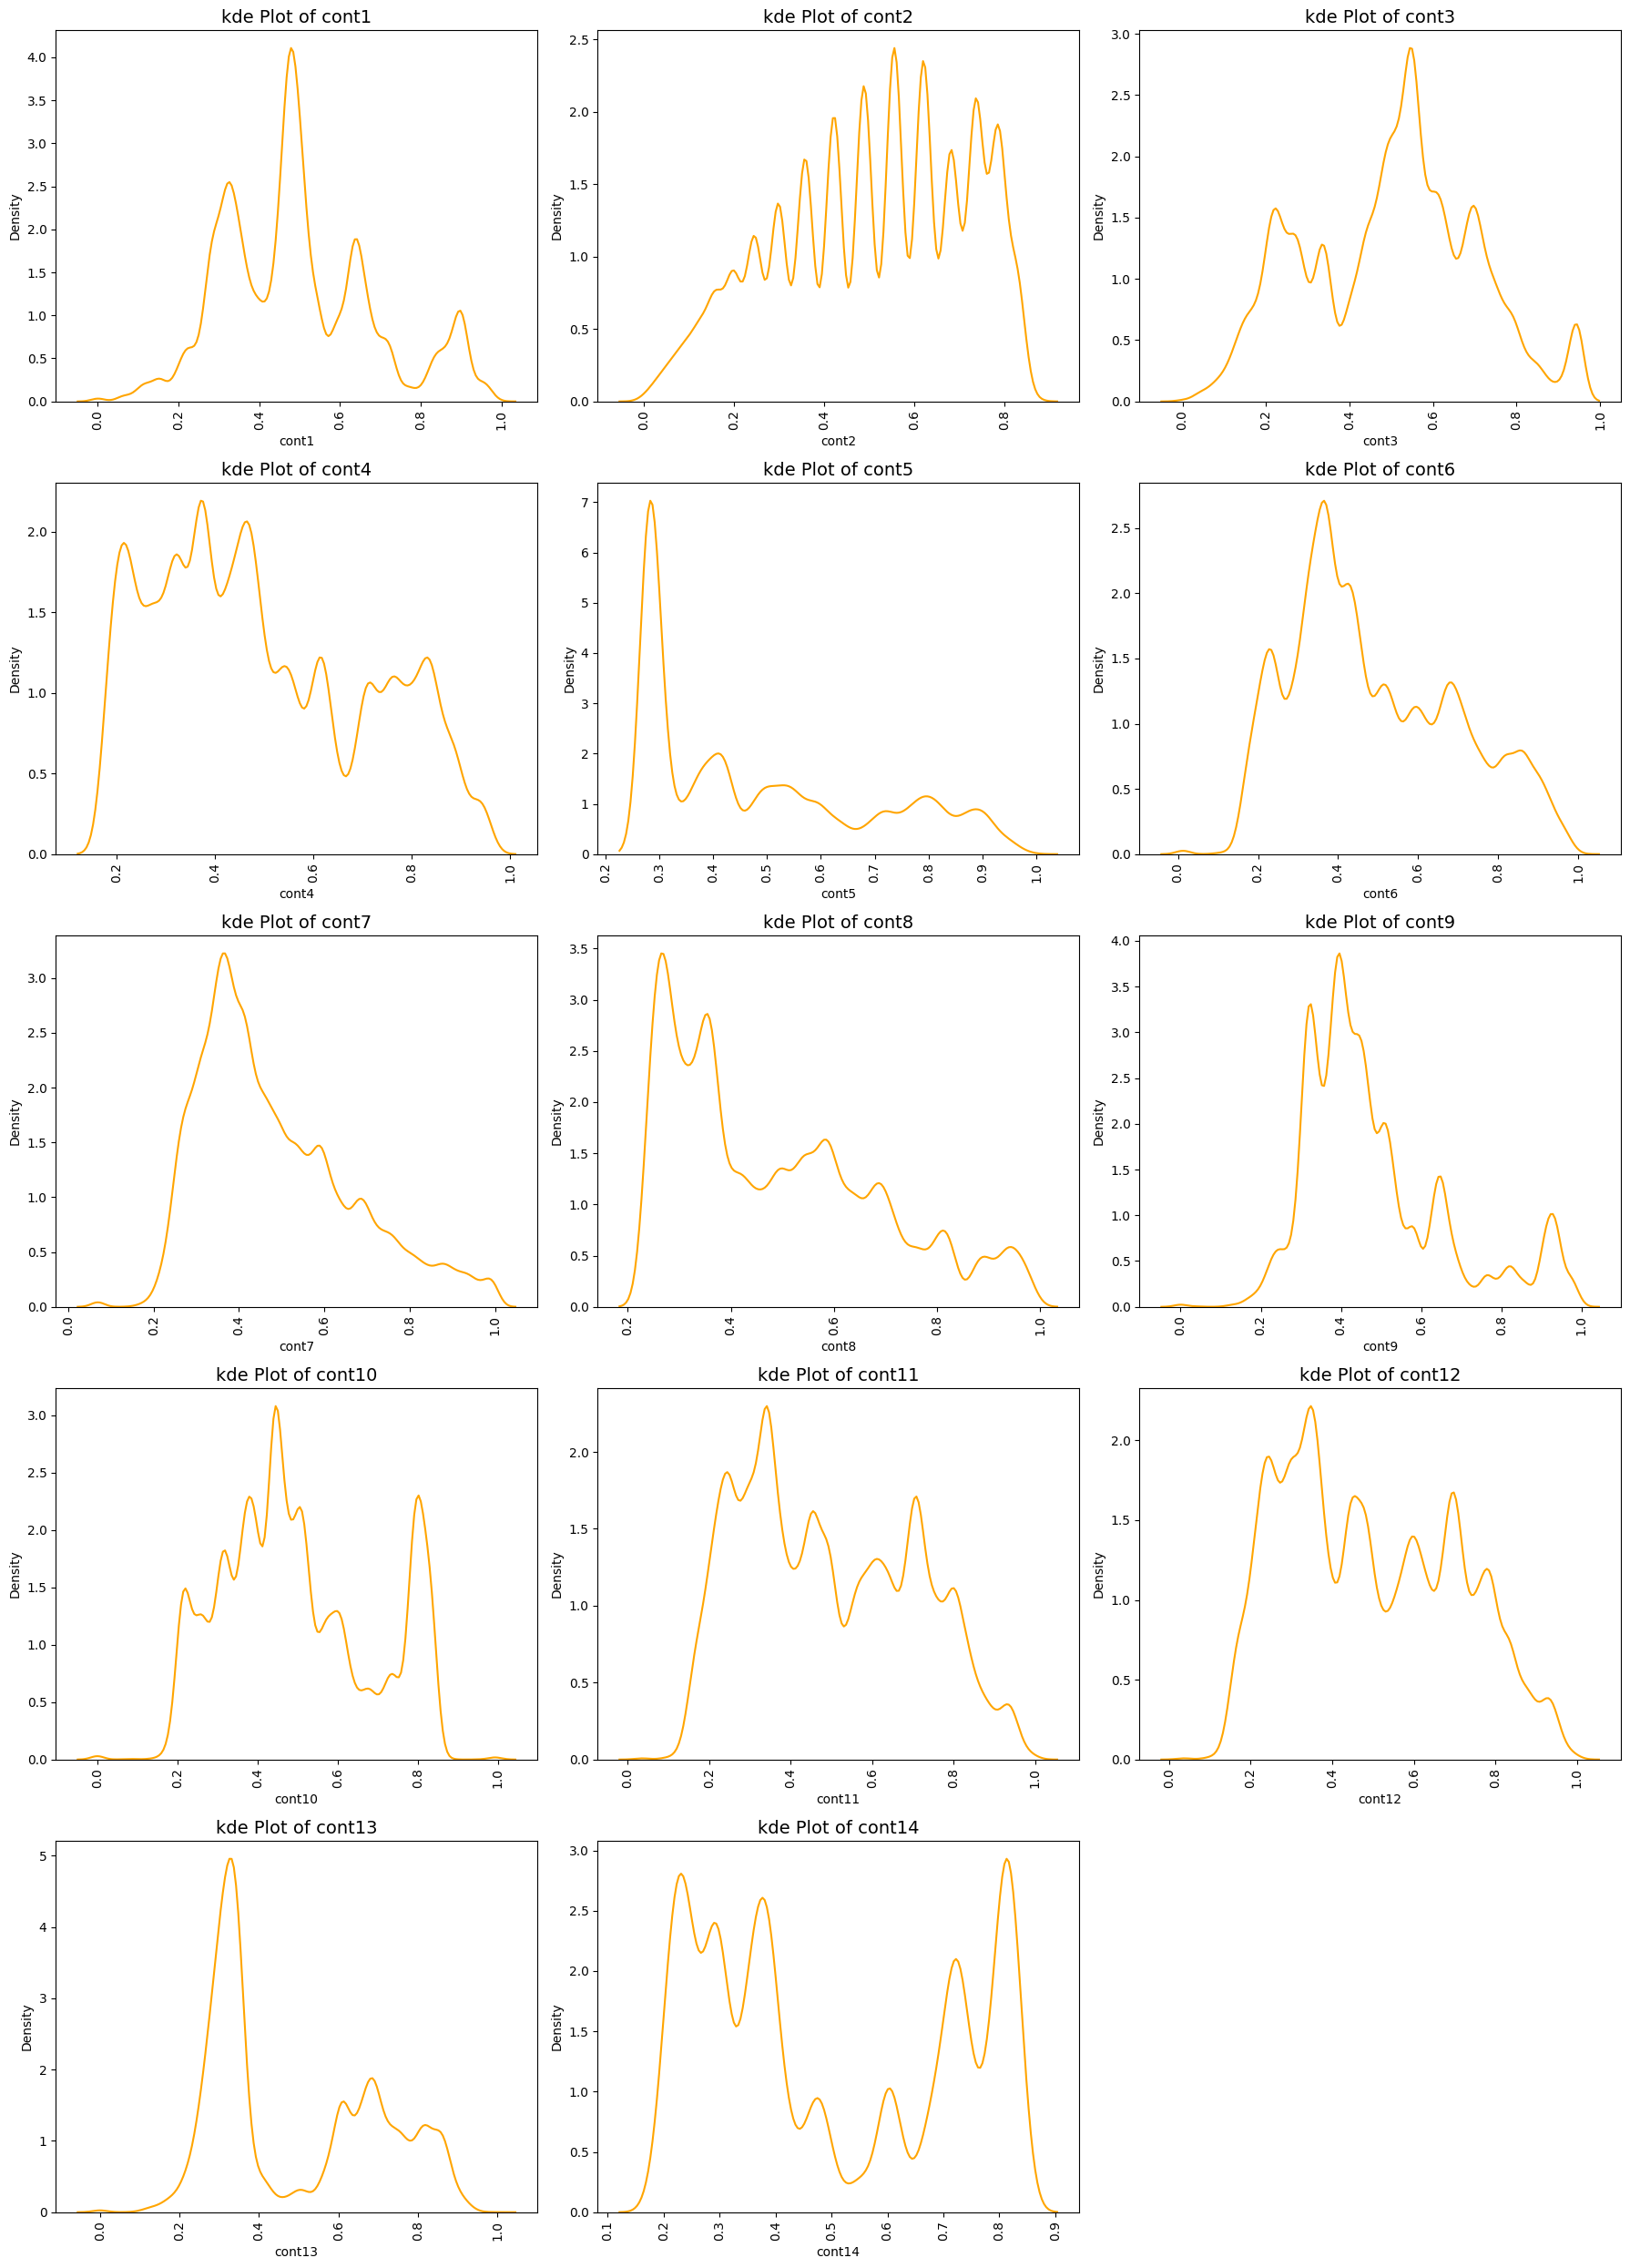

In [90]:
n_cols = 3
n_rows = math.ceil(len(num_cols)/n_cols)
fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 5 * n_rows))
axes = axes.flatten()
for ax, col in zip(axes, num_cols):
    sns.kdeplot(
        x=df[col],
        color="orange",
        ax=ax
    )
    ax.set_title(f"kde Plot of {col}", fontsize=14)
    ax.set_xlabel(col)
    ax.tick_params(axis="x", rotation=90)

# Remove unused subplots
for ax in axes[len(num_cols):]:
    ax.remove()

plt.tight_layout()
plt.show()

In [91]:
df[num_cols].skew()

cont1     0.516424
cont2    -0.310941
cont3    -0.010002
cont4     0.416096
cont5     0.681622
cont6     0.461214
cont7     0.826053
cont8     0.676634
cont9     1.072429
cont10    0.355001
cont11    0.280821
cont12    0.291992
cont13    0.380742
cont14    0.248674
dtype: float64

### **<span style="color:orange;">Log1p Transformation</span>**

In [92]:
log1p_df = df[num_cols].apply(np.log1p)
log1p_df

,cont1,cont2,cont3,cont4,cont5,cont6,cont7,cont8,cont9,cont10,cont11,cont12,cont13,cont14
0,0.545980,0.219875,0.171920,0.582014,0.270074,0.541374,0.288976,0.264362,0.513632,0.607099,0.450913,0.466652,0.600205,0.539322
1,0.285565,0.552199,0.465419,0.478799,0.634370,0.363891,0.362269,0.470547,0.301045,0.364080,0.291409,0.312111,0.477123,0.265817
2,0.232572,0.306248,0.394873,0.212628,0.334376,0.254369,0.274251,0.241533,0.231715,0.281005,0.323096,0.317307,0.178739,0.573476
3,0.278839,0.441978,0.423954,0.317592,0.352253,0.365299,0.330115,0.276085,0.278601,0.367881,0.283610,0.278820,0.473172,0.471654
4,0.241537,0.148411,0.423954,0.387438,0.533136,0.163982,0.221068,0.219649,0.199580,0.192519,0.186220,0.184164,0.219947,0.359495
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
188313,0.298179,0.579858,0.478505,0.387438,0.662459,0.217075,0.254603,0.219649,0.268950,0.284690,0.201338,0.198853,0.287651,0.189145
188314,0.410559,0.441978,0.438107,0.589392,0.533136,0.288384,0.323532,0.491490,0.339717,0.390548,0.268215,0.263841,0.276605,0.266871
188315,0.395057,0.579858,0.583543,0.173228,0.393687,0.297050,0.315200,0.219649,0.377121,0.390548,0.368534,0.366983,0.292105,0.408054
188316,0.363521,0.352203,0.261577,0.324564,0.293075,0.533192,0.446521,0.300008,0.369955,0.431009,0.622216,0.616733,0.503652,0.543316


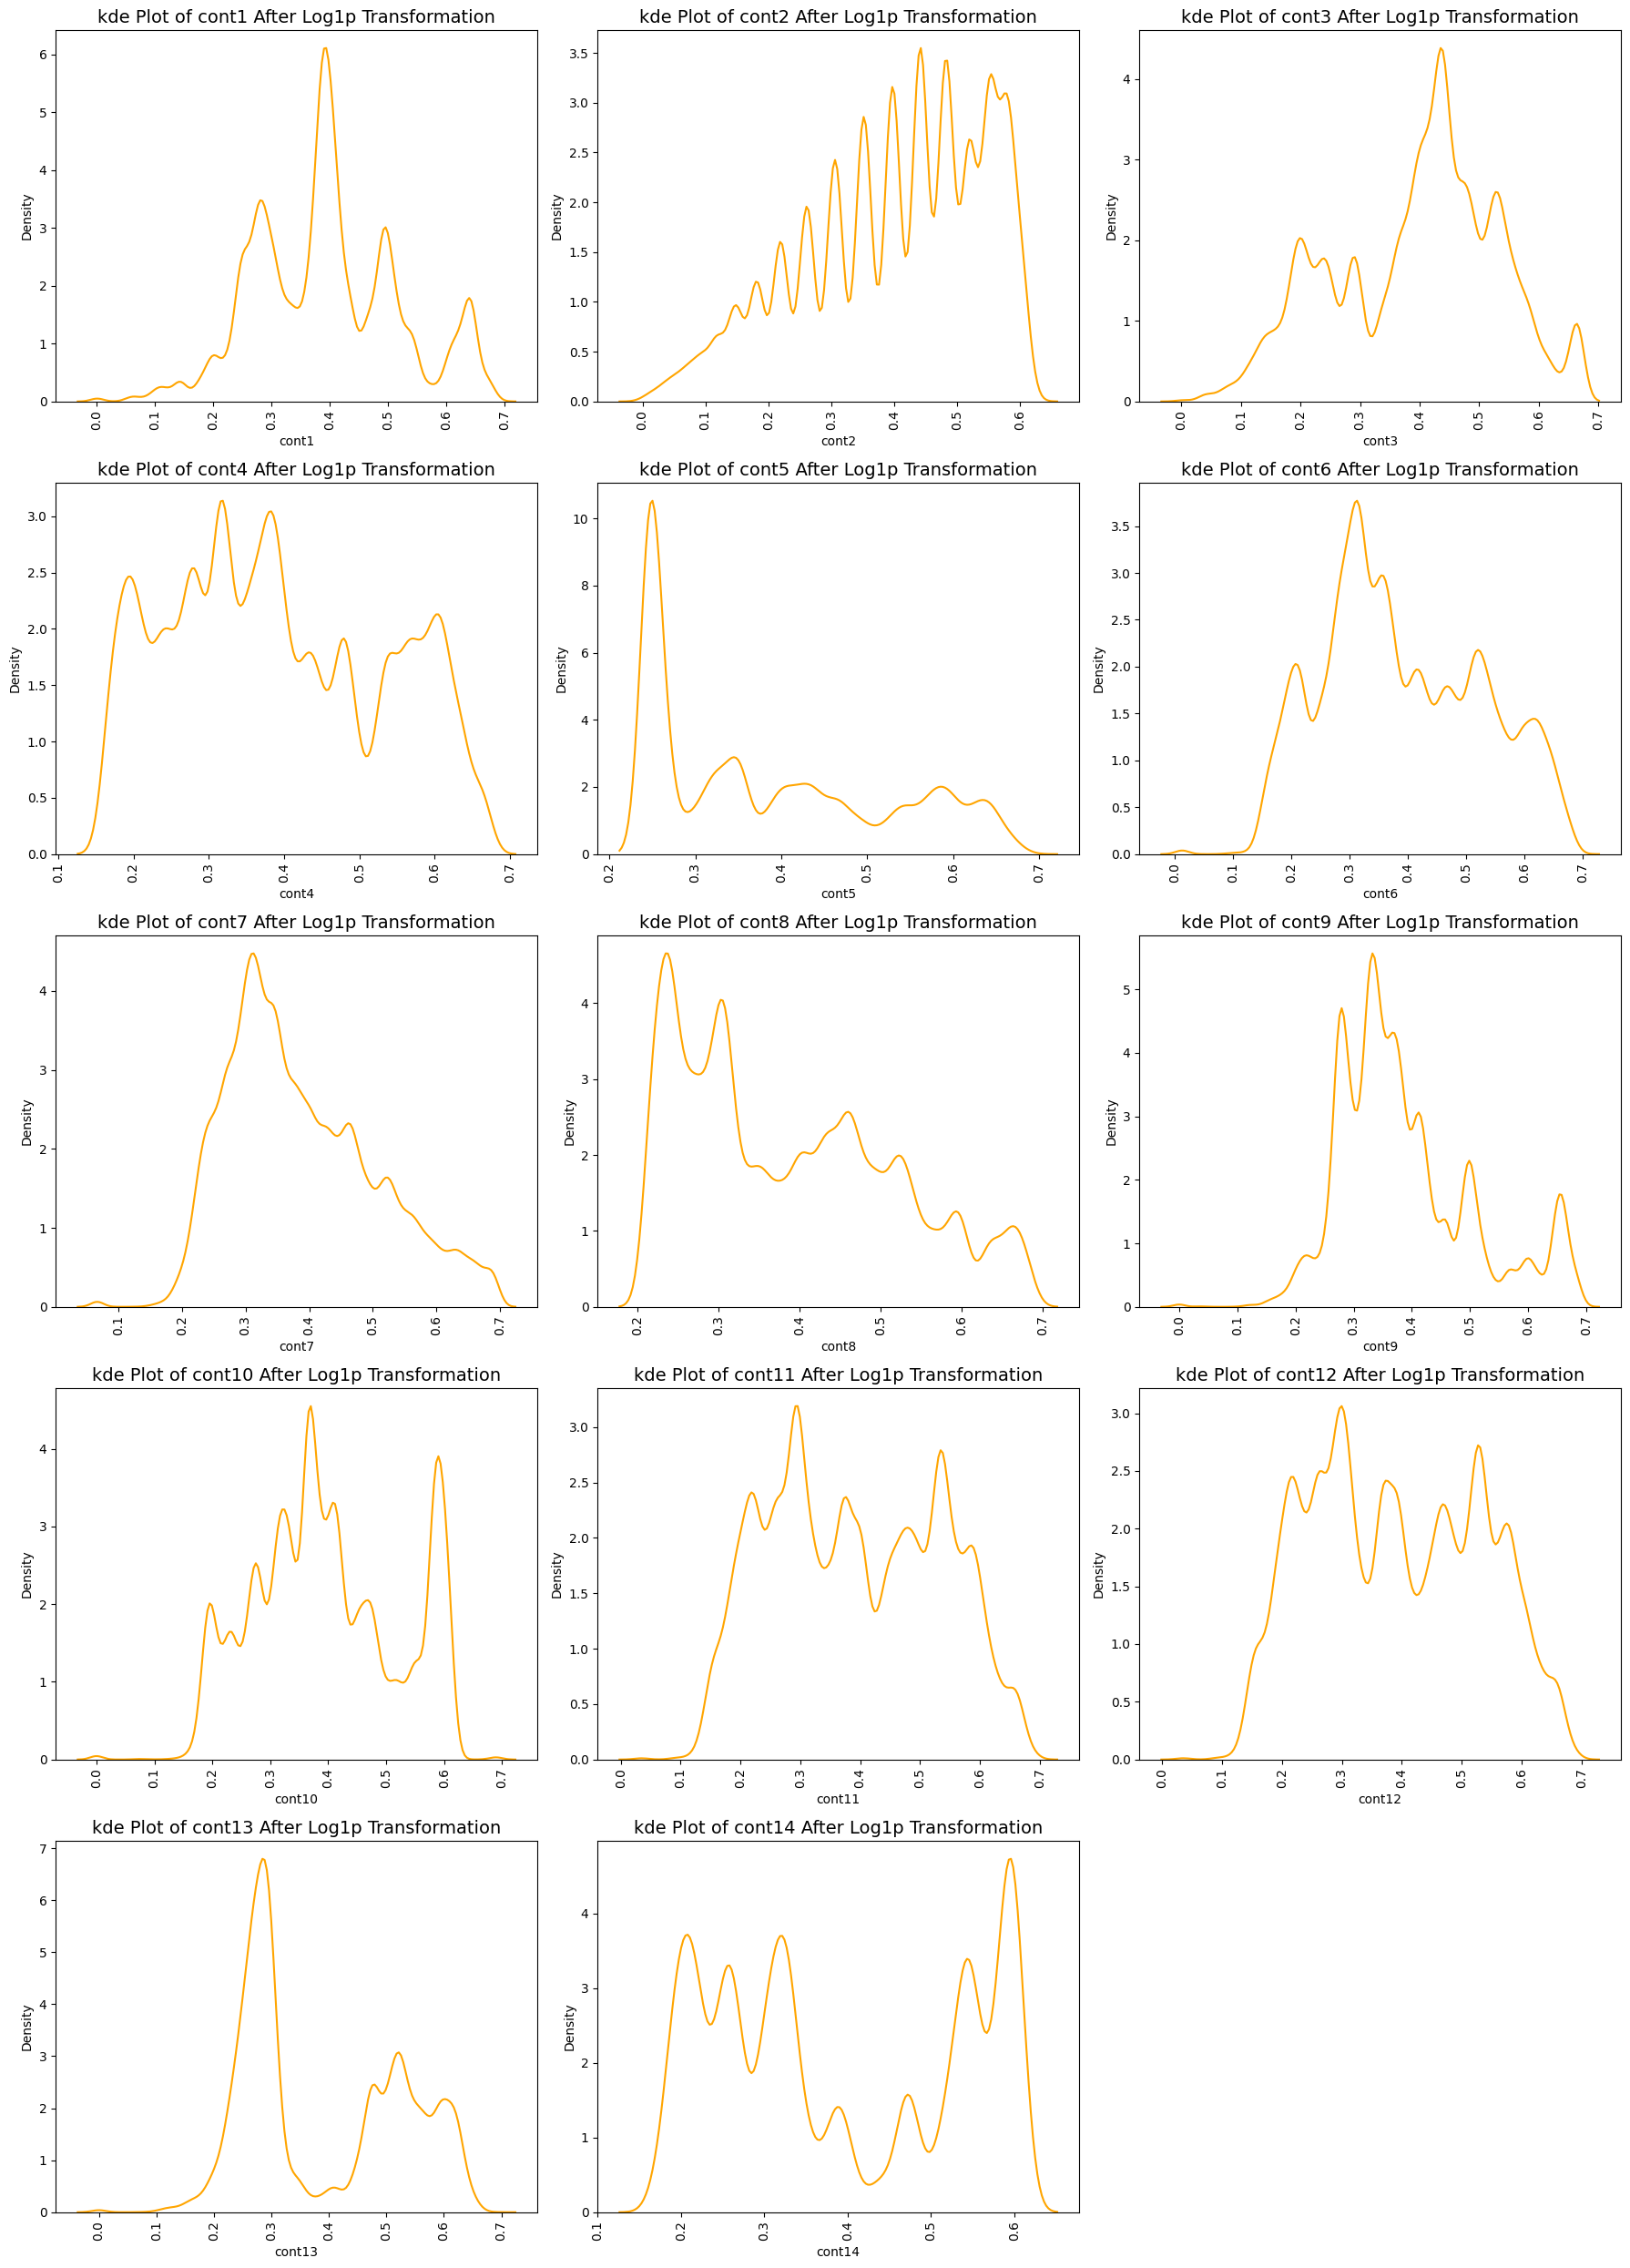

In [93]:
fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 5 * n_rows))
axes = axes.flatten()
for ax, col in zip(axes, num_cols):
    sns.kdeplot(
        x=log1p_df[col],
        color="orange",
        ax=ax
    )
    ax.set_title(f"kde Plot of {col} After Log1p Transformation", fontsize=14)
    ax.set_xlabel(col)
    ax.tick_params(axis="x", rotation=90)

# Remove unused subplots
for ax in axes[len(num_cols):]:
    ax.remove()

plt.tight_layout()
plt.show()

In [94]:
log1p_df[num_cols].skew()

cont1     0.201999
cont2    -0.537001
cont3    -0.284624
cont4     0.234676
cont5     0.552307
cont6     0.249939
cont7     0.593133
cont8     0.492940
cont9     0.814233
cont10    0.155137
cont11    0.101530
cont12    0.110061
cont13    0.272667
cont14    0.155156
dtype: float64

### **<span style="color:orange;">Yeo-Johnson Transformation</span>**

In [95]:
yeo_johnson_df = YeoJohnsonTransformer(variables=num_cols).fit_transform(df[num_cols])
yeo_johnson_df

,cont1,cont2,cont3,cont4,cont5,cont6,cont7,cont8,cont9,cont10,cont11,cont12,cont13,cont14
0,0.466582,0.276297,0.186527,0.442053,0.184779,0.422382,0.211609,0.198293,0.284491,0.505594,0.409230,0.418958,0.399444,0.428664
1,0.262748,1.010093,0.583282,0.381069,0.282758,0.307220,0.246518,0.287974,0.209284,0.325783,0.273601,0.290269,0.343408,0.236808
2,0.217282,0.422817,0.477742,0.191682,0.210680,0.225740,0.203864,0.185503,0.174384,0.257807,0.301304,0.294749,0.157276,0.449517
3,0.257055,0.710989,0.520405,0.272391,0.217033,0.308213,0.231919,0.204605,0.198663,0.328809,0.266724,0.261300,0.341437,0.385437
4,0.225074,0.172845,0.520405,0.321620,0.265262,0.151747,0.173619,0.172598,0.155964,0.181434,0.178837,0.176408,0.188063,0.307822
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
188313,0.273361,1.096108,0.603638,0.321620,0.286738,0.195985,0.193115,0.172598,0.193903,0.260898,0.192727,0.189831,0.234783,0.174132
188314,0.364505,0.710989,0.541593,0.446177,0.265262,0.251968,0.228796,0.294932,0.226203,0.346711,0.253079,0.248116,0.227474,0.237641
188315,0.352290,1.096108,0.776383,0.159149,0.230506,0.258514,0.224775,0.172598,0.241035,0.346711,0.340364,0.337038,0.237698,0.342375
188316,0.327091,0.511747,0.296384,0.277460,0.194626,0.417493,0.280057,0.216973,0.238304,0.378047,0.544729,0.535288,0.356354,0.431136


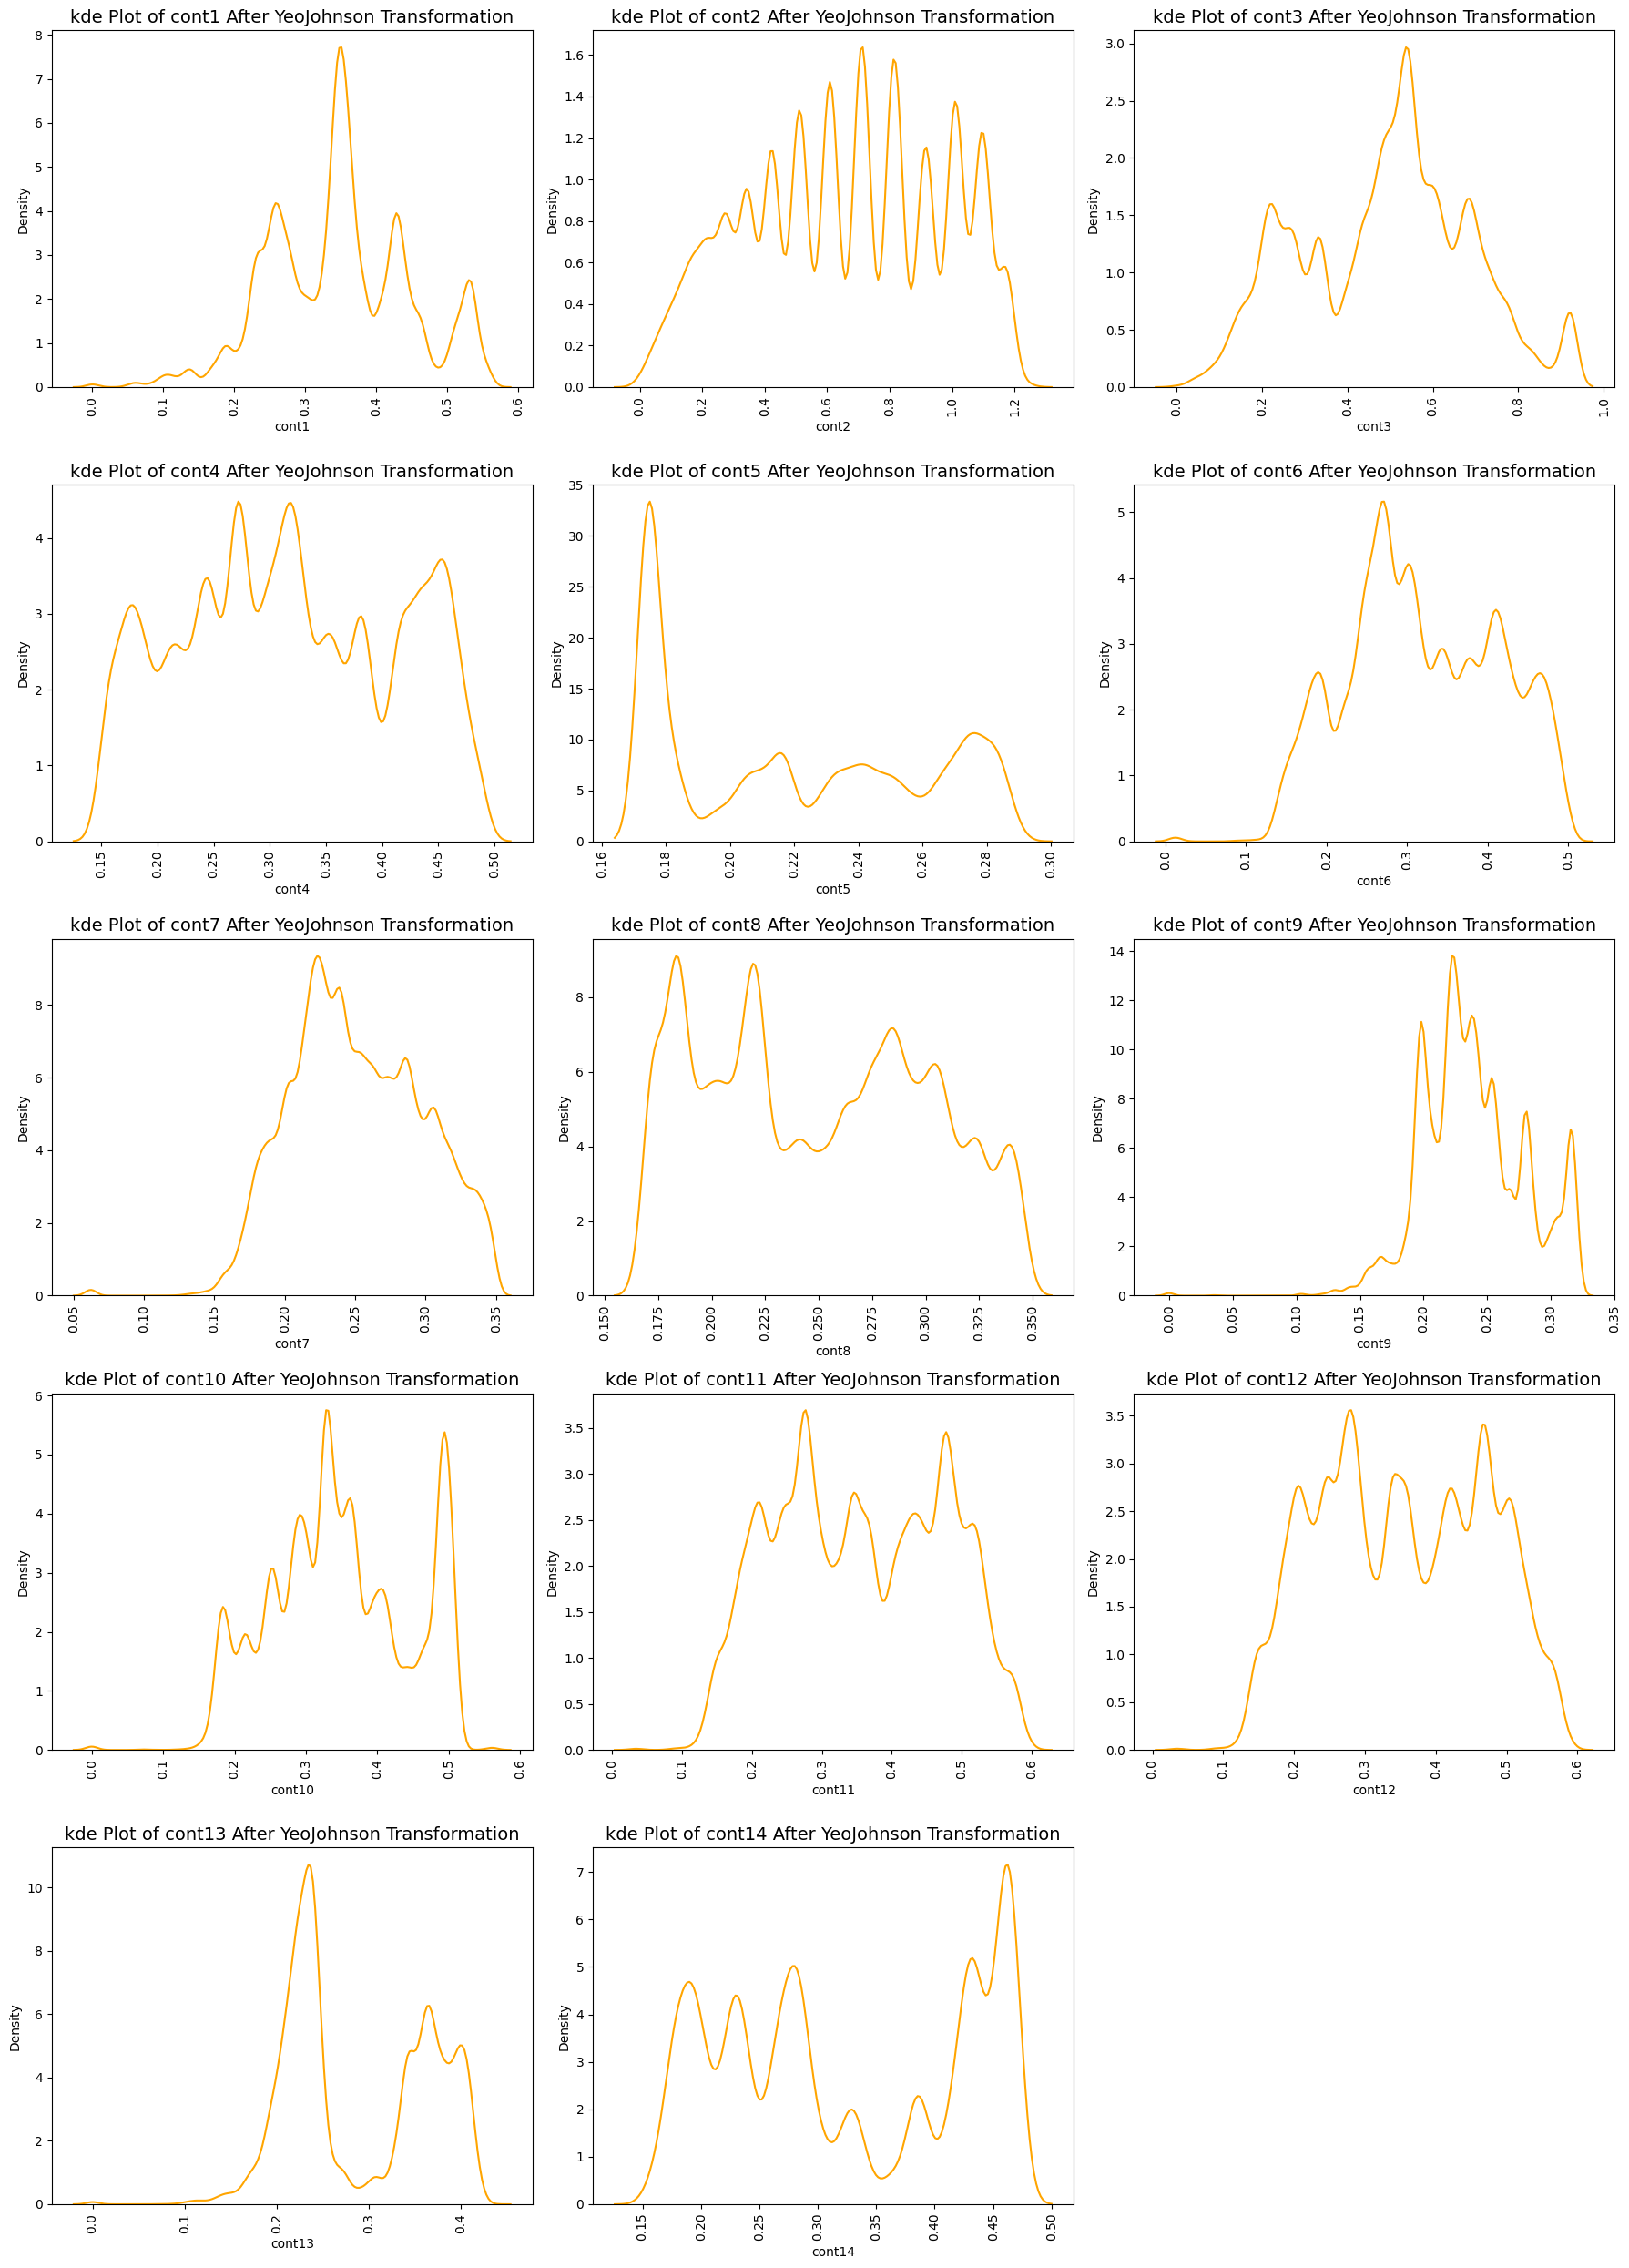

In [96]:
fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 5 * n_rows))
axes = axes.flatten()
for ax, col in zip(axes, num_cols):
    sns.kdeplot(
        x=yeo_johnson_df[col],
        color="orange",
        ax=ax
    )
    ax.set_title(f"kde Plot of {col} After YeoJohnson Transformation", fontsize=14)
    ax.set_xlabel(col)
    ax.tick_params(axis="x", rotation=90)

# Remove unused subplots
for ax in axes[len(num_cols):]:
    ax.remove()

plt.tight_layout()
plt.show()

In [97]:
yeo_johnson_df[num_cols].skew()

cont1     0.003913
cont2    -0.102177
cont3    -0.027912
cont4     0.051768
cont5     0.205931
cont6     0.038876
cont7     0.054278
cont8     0.124675
cont9    -0.012653
cont10    0.020272
cont11    0.023379
cont12    0.024830
cont13    0.093885
cont14    0.067617
dtype: float64

📌 Effect of Transformations on Numerical Feature Skewness

The original numerical features (cont1–cont14) exhibit mild to moderate skewness, with skewness values ranging from −0.31 to 1.07. Most variables are slightly right-skewed, while a few are near-symmetric, indicating moderate deviation from normality across the numerical feature set.

After applying the **log1p transformation**, a noticeable reduction in skewness is observed for the majority of features. Several variables move closer to symmetry, particularly those with initially higher positive skewness. However, some features retain moderate skewness, and a few become more negatively skewed, suggesting that log1p partially normalizes the distributions but does not fully eliminate asymmetry across all numerical variables.

In contrast, the **Yeo–Johnson transformation** results in a substantial and consistent reduction in skewness across all numerical features. Post-transformation skewness values are tightly centered around zero, with most features exhibiting skewness within ±0.10 and none showing pronounced asymmetry. This indicates that the Yeo–Johnson transformation is more effective in producing approximately symmetric distributions across the entire numerical feature set.

Overall, the comparative analysis demonstrates that while log1p improves distributional symmetry to a certain extent, the Yeo–Johnson transformation achieves a more uniform and near-normal distribution across numerical features.

# **<span style="color:orange;">Outliers</span>**

In [98]:
def iqr_outlier_counts(series, k=1.5):
    q1 = series.quantile(0.25)
    q3 = series.quantile(0.75)
    iqr_val = q3-q1

    lower = q1 - k * iqr_val
    upper = q3 + k * iqr_val

    below = (series < lower).sum()
    above = (series > upper).sum()

    return below, above

In [99]:
outlier_rows = []

for col in num_cols:
    below, above = iqr_outlier_counts(df[col])
    outlier_rows.append({
        "feature": col,
        "below_count": below,
        "above_count": above,
        "total_outliers": below + above
    })

outlier_df = pd.DataFrame(outlier_rows)
outlier_df

,feature,below_count,above_count,total_outliers
0,cont1,0,0,0
1,cont2,0,0,0
2,cont3,0,0,0
3,cont4,0,0,0
4,cont5,0,0,0
5,cont6,0,0,0
6,cont7,0,2659,2659
7,cont8,0,0,0
8,cont9,206,12988,13194
9,cont10,0,140,140


### **<span style="color:orange;">Creating Pipelines</span>**

In [100]:
categorical_pipe = Pipeline(
    steps=[
        ("rare_label", RareLabelEncoder(max_n_categories=10, replace_with='Other', missing_values='raise', n_categories=1)),
        ("ohe", OneHotEncoder(sparse_output=False))
    ]
)
categorical_pipe

,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('rare_label', ...), ('ohe', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,tol,0.05
,n_categories,1
,max_n_categories,10
,replace_with,'Other'
,variables,None
,missing_values,'raise'
,ignore_format,False


In [101]:
numerical_pipe = Pipeline(
    steps=[
        ("scaling", StandardScaler())
    ]
)
numerical_pipe

,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('scaling', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"copy copy: bool, default=TrueIf False, try to avoid a copy and do inplace scaling instead.This is not guaranteed to always work inplace; e.g. if the data isnot a NumPy array or scipy.sparse CSR matrix, a copy may still bereturned.",True
,"with_mean with_mean: bool, default=TrueIf True, center the data before scaling.This does not work (and will raise an exception) when attempted onsparse matrices, because centering them entails building a densematrix which in common use cases is likely to be too large to fit inmemory.",True
,"with_std with_std: bool, default=TrueIf True, scale the data to unit variance (or equivalently,unit standard deviation).",True


In [102]:
preprocessing_pipe = ColumnTransformer(
    transformers=[
        ('cat_pipe', categorical_pipe, cat_cols),
        ('num_pipe', numerical_pipe, num_cols)
    ]
)

In [103]:
preprocessing_pipe

,"transformers transformers: list of tuplesList of (name, transformer, columns) tuples specifying thetransformer objects to be applied to subsets of the data.name : str Like in Pipeline and FeatureUnion, this allows the transformer and its parameters to be set using ``set_params`` and searched in grid search.transformer : {'drop', 'passthrough'} or estimator Estimator must support :term:`fit` and :term:`transform`. Special-cased strings 'drop' and 'passthrough' are accepted as well, to indicate to drop the columns or to pass them through untransformed, respectively.columns : str, array-like of str, int, array-like of int, array-like of bool, slice or callable Indexes the data on its second axis. Integers are interpreted as positional columns, while strings can reference DataFrame columns by name. A scalar string or int should be used where ``transformer`` expects X to be a 1d array-like (vector), otherwise a 2d array will be passed to the transformer. A callable is passed the input data `X` and can return any of the above. To select multiple columns by name or dtype, you can use :obj:`make_column_selector`.","[('cat_pipe', ...), ('num_pipe', ...)]"
,"remainder remainder: {'drop', 'passthrough'} or estimator, default='drop'By default, only the specified columns in `transformers` aretransformed and combined in the output, and the non-specifiedcolumns are dropped. (default of ``'drop'``).By specifying ``remainder='passthrough'``, all remaining columns thatwere not specified in `transformers`, but present in the data passedto `fit` will be automatically passed through. This subset of columnsis concatenated with the output of the transformers. For dataframes,extra columns not seen during `fit` will be excluded from the outputof `transform`.By setting ``remainder`` to be an estimator, the remainingnon-specified columns will use the ``remainder`` estimator. Theestimator must support :term:`fit` and :term:`transform`.Note that using this feature requires that the DataFrame columnsinput at :term:`fit` and :term:`transform` have identical order.",'drop'
,"sparse_threshold sparse_threshold: float, default=0.3If the output of the different transformers contains sparse matrices,these will be stacked as a sparse matrix if the overall density islower than this value. Use ``sparse_threshold=0`` to always returndense. When the transformed output consists of all dense data, thestacked result will be dense, and this keyword will be ignored.",0.3
,"n_jobs n_jobs: int, default=NoneNumber of jobs to run in parallel.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details.",None
,"transformer_weights transformer_weights: dict, default=NoneMultiplicative weights for features per transformer. The output of thetransformer is multiplied by these weights. Keys are transformer names,values the weights.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each transformer will beprinted as it is completed.",False
,"verbose_feature_names_out verbose_feature_names_out: bool, str or Callable[[str, str], str], default=True- If True, :meth:`ColumnTransformer.get_feature_names_out` will prefix all feature names with the name of the transformer that generated that feature. It is equivalent to setting `verbose_feature_names_out=""{transformer_name}__{feature_name}""`.- If False, :meth:`ColumnTransformer.get_feature_names_out` will not prefix any feature names and will error if feature names are not unique.- If ``Callable[[str, str], str]``, :meth:`ColumnTransformer.get_feature_names_out` will rename all the features using the name of the transformer. The first argument of the callable is the transformer name and the second argument is the feature name. The returned string will be the new feature name.- If ``str``, it must be a string ready for formatting. The given string will be formatted using two field names: ``transformer_name`` and ``feature_name

### **<span style="color:orange;">Train-Test Split</span>**

In [104]:
X = df.drop('loss', axis=1)
y = df['loss']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)

In [105]:
X_train_final = preprocessing_pipe.fit_transform(X_train, y_train)
X_test_final = preprocessing_pipe.transform(X_train)

In [106]:
X_train_final

,cat_pipe__cat1_A,cat_pipe__cat1_B,cat_pipe__cat2_A,cat_pipe__cat2_B,cat_pipe__cat3_A,cat_pipe__cat3_B,cat_pipe__cat4_A,cat_pipe__cat4_B,cat_pipe__cat5_A,cat_pipe__cat5_B,cat_pipe__cat6_A,cat_pipe__cat6_B,cat_pipe__cat7_A,cat_pipe__cat7_Other,cat_pipe__cat8_A,cat_pipe__cat8_B,cat_pipe__cat9_A,cat_pipe__cat9_B,cat_pipe__cat10_A,cat_pipe__cat10_B,cat_pipe__cat11_A,cat_pipe__cat11_B,cat_pipe__cat12_A,cat_pipe__cat12_B,cat_pipe__cat13_A,cat_pipe__cat13_B,cat_pipe__cat14_A,cat_pipe__cat14_Other,cat_pipe__cat15_A,cat_pipe__cat15_Other,cat_pipe__cat16_A,cat_pipe__cat16_Other,cat_pipe__cat17_A,cat_pipe__cat17_Other,cat_pipe__cat18_A,cat_pipe__cat18_Other,cat_pipe__cat19_A,cat_pipe__cat19_Other,cat_pipe__cat20_A,cat_pipe__cat20_Other,cat_pipe__cat21_A,cat_pipe__cat21_Other,cat_pipe__cat22_A,cat_pipe__cat22_Other,cat_pipe__cat23_A,cat_pipe__cat23_B,cat_pipe__cat24_A,cat_pipe__cat24_Other,cat_pipe__cat25_A,cat_pipe__cat25_B,cat_pipe__cat26_A,cat_pipe__cat26_B,cat_pipe__cat27_A,cat_pipe__cat27_B,cat_pipe__cat28_A,cat_pipe__cat28_Other,cat_pipe__cat29_A,cat_pipe__cat29_Other,cat_pipe__cat30_A,cat_pipe__cat30_Other,cat_pipe__cat31_A,cat_pipe__cat31_Other,cat_pipe__cat32_A,cat_pipe__cat32_Other,cat_pipe__cat33_A,cat_pipe__cat33_Other,cat_pipe__cat34_A,cat_pipe__cat34_Other,cat_pipe__cat35_A,cat_pipe__cat35_Other,cat_pipe__cat36_A,cat_pipe__cat36_B,cat_pipe__cat37_A,cat_pipe__cat37_B,cat_pipe__cat38_A,cat_pipe__cat38_B,cat_pipe__cat39_A,cat_pipe__cat39_Other,cat_pipe__cat40_A,cat_pipe__cat40_Other,cat_pipe__cat41_A,cat_pipe__cat41_Other,cat_pipe__cat42_A,cat_pipe__cat42_Other,cat_pipe__cat43_A,cat_pipe__cat43_Other,cat_pipe__cat44_A,cat_pipe__cat44_B,cat_pipe__cat45_A,cat_pipe__cat45_Other,cat_pipe__cat46_A,cat_pipe__cat46_Other,cat_pipe__cat47_A,cat_pipe__cat47_Other,cat_pipe__cat48_A,cat_pipe__cat48_Other,cat_pipe__cat49_A,cat_pipe__cat49_Other,cat_pipe__cat50_A,cat_pipe__cat50_B,cat_pipe__cat51_A,cat_pipe__cat51_Other,cat_pipe__cat52_A,cat_pipe__cat52_Other,cat_pipe__cat53_A,cat_pipe__cat53_B,cat_pipe__cat54_A,cat_pipe__cat54_Other,cat_pipe__cat55_A,cat_pipe__cat55_Other,cat_pipe__cat56_A,cat_pipe__cat56_Other,cat_pipe__cat57_A,cat_pipe__cat57_Other,cat_pipe__cat58_A,cat_pipe__cat58_Other,cat_pipe__cat59_A,cat_pipe__cat59_Other,cat_pipe__cat60_A,cat_pipe__cat60_Other,cat_pipe__cat61_A,cat_pipe__cat61_Other,cat_pipe__cat62_A,cat_pipe__cat62_Other,cat_pipe__cat63_A,cat_pipe__cat63_Other,cat_pipe__cat64_A,cat_pipe__cat64_Other,cat_pipe__cat65_A,cat_pipe__cat65_Other,cat_pipe__cat66_A,cat_pipe__cat66_Other,cat_pipe__cat67_A,cat_pipe__cat67_Other,cat_pipe__cat68_A,cat_pipe__cat68_Other,cat_pipe__cat69_A,cat_pipe__cat69_Other,cat_pipe__cat70_A,cat_pipe__cat70_Other,cat_pipe__cat71_A,cat_pipe__cat71_B,cat_pipe__cat72_A,cat_pipe__cat72_B,cat_pipe__cat73_A,cat_pipe__cat73_B,cat_pipe__cat73_Other,cat_pipe__cat74_A,cat_pipe__cat74_Other,cat_pipe__cat75_A,cat_pipe__cat75_B,cat_pipe__cat75_Other,cat_pipe__cat76_A,cat_pipe__cat76_Other,cat_pipe__cat77_D,cat_pipe__cat77_Other,cat_pipe__cat78_B,cat_pipe__cat78_Other,cat_pipe__cat79_B,cat_pipe__cat79_D,cat_pipe__cat79_Other,cat_pipe__cat80_B,cat_pipe__cat80_D,cat_pipe__cat80_Other,cat_pipe__cat81_B,cat_pipe__cat81_D,cat_pipe__cat81_Other,cat_pipe__cat82_A,cat_pipe__cat82_B,cat_pipe__cat82_D,cat_pipe__cat82_Other,cat_pipe__cat83_A,cat_pipe__cat83_B,cat_pipe__cat83_D,cat_pipe__cat83_Other,cat_pipe__cat84_A,cat_pipe__cat84_C,cat_pipe__cat84_Other,cat_pipe__cat85_B,cat_pipe__cat85_Other,cat_pipe__cat86_B,cat_pipe__cat86_C,cat_pipe__cat86_D,cat_pipe__cat86_Other,cat_pipe__cat87_B,cat_pipe__cat87_D,cat_pipe__cat87_Other,cat_pipe__cat88_A,cat_pipe__cat88_D,cat_pipe__cat88_Other,cat_pipe__cat89_A,cat_pipe__cat89_Other,cat_pipe__cat90_A,cat_pipe__cat90_B,cat_pipe__cat90_Other,cat_pipe__cat91_A,cat_pipe__cat91_B,cat_pipe__cat91_G,cat_pipe__cat91_Other,cat_pipe__cat92_A,cat_pipe__cat92_H,cat_pipe__cat92_Other,cat_pipe__cat93_C,cat_pipe__cat93_D,cat_pipe__cat93_Other,cat_pipe__cat94_B,cat_pipe__cat94_C,cat_pipe__cat94

# **<span style="color:orange;">Feature Selection</span>**

### **<span style="color:orange;">Constant Variance Feature</span>**

In [109]:
drop_constant = DropConstantFeatures()
drop_constant.fit_transform(X_train_final)

,cat_pipe__cat1_A,cat_pipe__cat1_B,cat_pipe__cat2_A,cat_pipe__cat2_B,cat_pipe__cat3_A,cat_pipe__cat3_B,cat_pipe__cat4_A,cat_pipe__cat4_B,cat_pipe__cat5_A,cat_pipe__cat5_B,cat_pipe__cat6_A,cat_pipe__cat6_B,cat_pipe__cat7_A,cat_pipe__cat7_Other,cat_pipe__cat8_A,cat_pipe__cat8_B,cat_pipe__cat9_A,cat_pipe__cat9_B,cat_pipe__cat10_A,cat_pipe__cat10_B,cat_pipe__cat11_A,cat_pipe__cat11_B,cat_pipe__cat12_A,cat_pipe__cat12_B,cat_pipe__cat13_A,cat_pipe__cat13_B,cat_pipe__cat14_A,cat_pipe__cat14_Other,cat_pipe__cat15_A,cat_pipe__cat15_Other,cat_pipe__cat16_A,cat_pipe__cat16_Other,cat_pipe__cat17_A,cat_pipe__cat17_Other,cat_pipe__cat18_A,cat_pipe__cat18_Other,cat_pipe__cat19_A,cat_pipe__cat19_Other,cat_pipe__cat20_A,cat_pipe__cat20_Other,cat_pipe__cat21_A,cat_pipe__cat21_Other,cat_pipe__cat22_A,cat_pipe__cat22_Other,cat_pipe__cat23_A,cat_pipe__cat23_B,cat_pipe__cat24_A,cat_pipe__cat24_Other,cat_pipe__cat25_A,cat_pipe__cat25_B,cat_pipe__cat26_A,cat_pipe__cat26_B,cat_pipe__cat27_A,cat_pipe__cat27_B,cat_pipe__cat28_A,cat_pipe__cat28_Other,cat_pipe__cat29_A,cat_pipe__cat29_Other,cat_pipe__cat30_A,cat_pipe__cat30_Other,cat_pipe__cat31_A,cat_pipe__cat31_Other,cat_pipe__cat32_A,cat_pipe__cat32_Other,cat_pipe__cat33_A,cat_pipe__cat33_Other,cat_pipe__cat34_A,cat_pipe__cat34_Other,cat_pipe__cat35_A,cat_pipe__cat35_Other,cat_pipe__cat36_A,cat_pipe__cat36_B,cat_pipe__cat37_A,cat_pipe__cat37_B,cat_pipe__cat38_A,cat_pipe__cat38_B,cat_pipe__cat39_A,cat_pipe__cat39_Other,cat_pipe__cat40_A,cat_pipe__cat40_Other,cat_pipe__cat41_A,cat_pipe__cat41_Other,cat_pipe__cat42_A,cat_pipe__cat42_Other,cat_pipe__cat43_A,cat_pipe__cat43_Other,cat_pipe__cat44_A,cat_pipe__cat44_B,cat_pipe__cat45_A,cat_pipe__cat45_Other,cat_pipe__cat46_A,cat_pipe__cat46_Other,cat_pipe__cat47_A,cat_pipe__cat47_Other,cat_pipe__cat48_A,cat_pipe__cat48_Other,cat_pipe__cat49_A,cat_pipe__cat49_Other,cat_pipe__cat50_A,cat_pipe__cat50_B,cat_pipe__cat51_A,cat_pipe__cat51_Other,cat_pipe__cat52_A,cat_pipe__cat52_Other,cat_pipe__cat53_A,cat_pipe__cat53_B,cat_pipe__cat54_A,cat_pipe__cat54_Other,cat_pipe__cat55_A,cat_pipe__cat55_Other,cat_pipe__cat56_A,cat_pipe__cat56_Other,cat_pipe__cat57_A,cat_pipe__cat57_Other,cat_pipe__cat58_A,cat_pipe__cat58_Other,cat_pipe__cat59_A,cat_pipe__cat59_Other,cat_pipe__cat60_A,cat_pipe__cat60_Other,cat_pipe__cat61_A,cat_pipe__cat61_Other,cat_pipe__cat62_A,cat_pipe__cat62_Other,cat_pipe__cat63_A,cat_pipe__cat63_Other,cat_pipe__cat64_A,cat_pipe__cat64_Other,cat_pipe__cat65_A,cat_pipe__cat65_Other,cat_pipe__cat66_A,cat_pipe__cat66_Other,cat_pipe__cat67_A,cat_pipe__cat67_Other,cat_pipe__cat68_A,cat_pipe__cat68_Other,cat_pipe__cat69_A,cat_pipe__cat69_Other,cat_pipe__cat70_A,cat_pipe__cat70_Other,cat_pipe__cat71_A,cat_pipe__cat71_B,cat_pipe__cat72_A,cat_pipe__cat72_B,cat_pipe__cat73_A,cat_pipe__cat73_B,cat_pipe__cat73_Other,cat_pipe__cat74_A,cat_pipe__cat74_Other,cat_pipe__cat75_A,cat_pipe__cat75_B,cat_pipe__cat75_Other,cat_pipe__cat76_A,cat_pipe__cat76_Other,cat_pipe__cat77_D,cat_pipe__cat77_Other,cat_pipe__cat78_B,cat_pipe__cat78_Other,cat_pipe__cat79_B,cat_pipe__cat79_D,cat_pipe__cat79_Other,cat_pipe__cat80_B,cat_pipe__cat80_D,cat_pipe__cat80_Other,cat_pipe__cat81_B,cat_pipe__cat81_D,cat_pipe__cat81_Other,cat_pipe__cat82_A,cat_pipe__cat82_B,cat_pipe__cat82_D,cat_pipe__cat82_Other,cat_pipe__cat83_A,cat_pipe__cat83_B,cat_pipe__cat83_D,cat_pipe__cat83_Other,cat_pipe__cat84_A,cat_pipe__cat84_C,cat_pipe__cat84_Other,cat_pipe__cat85_B,cat_pipe__cat85_Other,cat_pipe__cat86_B,cat_pipe__cat86_C,cat_pipe__cat86_D,cat_pipe__cat86_Other,cat_pipe__cat87_B,cat_pipe__cat87_D,cat_pipe__cat87_Other,cat_pipe__cat88_A,cat_pipe__cat88_D,cat_pipe__cat88_Other,cat_pipe__cat89_A,cat_pipe__cat89_Other,cat_pipe__cat90_A,cat_pipe__cat90_B,cat_pipe__cat90_Other,cat_pipe__cat91_A,cat_pipe__cat91_B,cat_pipe__cat91_G,cat_pipe__cat91_Other,cat_pipe__cat92_A,cat_pipe__cat92_H,cat_pipe__cat92_Other,cat_pipe__cat93_C,cat_pipe__cat93_D,cat_pipe__cat93_Other,cat_pipe__cat94_B,cat_pipe__cat94_C,cat_pipe__cat94

In [110]:
drop_constant.features_to_drop_

[]

### **<span style="color:orange;">Correlated Feature</span>**

In [111]:
corr_featues = DropCorrelatedFeatures()
corr_featues.fit_transform(X_train_final)

,cat_pipe__cat1_A,cat_pipe__cat3_A,cat_pipe__cat10_A,cat_pipe__cat11_A,cat_pipe__cat12_A,cat_pipe__cat13_A,cat_pipe__cat14_A,cat_pipe__cat15_A,cat_pipe__cat16_A,cat_pipe__cat17_A,cat_pipe__cat18_A,cat_pipe__cat19_A,cat_pipe__cat20_A,cat_pipe__cat21_A,cat_pipe__cat22_A,cat_pipe__cat23_A,cat_pipe__cat24_A,cat_pipe__cat25_A,cat_pipe__cat26_A,cat_pipe__cat27_A,cat_pipe__cat28_A,cat_pipe__cat29_A,cat_pipe__cat30_A,cat_pipe__cat31_A,cat_pipe__cat32_A,cat_pipe__cat33_A,cat_pipe__cat34_A,cat_pipe__cat35_A,cat_pipe__cat36_A,cat_pipe__cat37_A,cat_pipe__cat38_A,cat_pipe__cat39_A,cat_pipe__cat40_A,cat_pipe__cat41_A,cat_pipe__cat42_A,cat_pipe__cat43_A,cat_pipe__cat44_A,cat_pipe__cat45_A,cat_pipe__cat46_A,cat_pipe__cat47_A,cat_pipe__cat48_A,cat_pipe__cat49_A,cat_pipe__cat51_A,cat_pipe__cat52_A,cat_pipe__cat53_A,cat_pipe__cat54_A,cat_pipe__cat55_A,cat_pipe__cat56_A,cat_pipe__cat57_A,cat_pipe__cat58_A,cat_pipe__cat59_A,cat_pipe__cat60_A,cat_pipe__cat61_A,cat_pipe__cat62_A,cat_pipe__cat63_A,cat_pipe__cat64_A,cat_pipe__cat65_A,cat_pipe__cat67_A,cat_pipe__cat68_A,cat_pipe__cat69_A,cat_pipe__cat70_A,cat_pipe__cat71_A,cat_pipe__cat72_A,cat_pipe__cat73_A,cat_pipe__cat73_Other,cat_pipe__cat74_A,cat_pipe__cat75_A,cat_pipe__cat75_Other,cat_pipe__cat76_A,cat_pipe__cat77_D,cat_pipe__cat78_B,cat_pipe__cat79_B,cat_pipe__cat79_Other,cat_pipe__cat80_B,cat_pipe__cat80_Other,cat_pipe__cat81_B,cat_pipe__cat81_Other,cat_pipe__cat82_A,cat_pipe__cat82_B,cat_pipe__cat82_D,cat_pipe__cat82_Other,cat_pipe__cat83_A,cat_pipe__cat83_B,cat_pipe__cat83_D,cat_pipe__cat83_Other,cat_pipe__cat84_A,cat_pipe__cat84_Other,cat_pipe__cat85_B,cat_pipe__cat86_B,cat_pipe__cat86_Other,cat_pipe__cat87_B,cat_pipe__cat87_D,cat_pipe__cat87_Other,cat_pipe__cat88_Other,cat_pipe__cat90_Other,cat_pipe__cat91_A,cat_pipe__cat91_B,cat_pipe__cat91_Other,cat_pipe__cat92_Other,cat_pipe__cat93_C,cat_pipe__cat93_Other,cat_pipe__cat94_B,cat_pipe__cat94_C,cat_pipe__cat94_Other,cat_pipe__cat95_C,cat_pipe__cat95_E,cat_pipe__cat95_Other,cat_pipe__cat96_E,cat_pipe__cat97_A,cat_pipe__cat97_C,cat_pipe__cat97_E,cat_pipe__cat97_G,cat_pipe__cat97_Other,cat_pipe__cat98_Other,cat_pipe__cat99_Other,cat_pipe__cat100_F,cat_pipe__cat100_G,cat_pipe__cat100_H,cat_pipe__cat100_I,cat_pipe__cat100_J,cat_pipe__cat100_K,cat_pipe__cat100_L,cat_pipe__cat100_Other,cat_pipe__cat101_A,cat_pipe__cat101_C,cat_pipe__cat101_D,cat_pipe__cat101_F,cat_pipe__cat101_G,cat_pipe__cat101_Other,cat_pipe__cat102_A,cat_pipe__cat103_A,cat_pipe__cat103_B,cat_pipe__cat103_C,cat_pipe__cat103_Other,cat_pipe__cat104_D,cat_pipe__cat104_E,cat_pipe__cat104_F,cat_pipe__cat104_G,cat_pipe__cat104_H,cat_pipe__cat104_I,cat_pipe__cat104_K,cat_pipe__cat104_Other,cat_pipe__cat105_D,cat_pipe__cat105_E,cat_pipe__cat105_F,cat_pipe__cat105_G,cat_pipe__cat105_H,cat_pipe__cat105_Other,cat_pipe__cat106_E,cat_pipe__cat106_F,cat_pipe__cat106_G,cat_pipe__cat106_H,cat_pipe__cat106_I,cat_pipe__cat106_J,cat_pipe__cat106_Other,cat_pipe__cat107_E,cat_pipe__cat107_F,cat_pipe__cat107_G,cat_pipe__cat107_H,cat_pipe__cat107_I,cat_pipe__cat107_J,cat_pipe__cat107_K,cat_pipe__cat107_Other,cat_pipe__cat108_B,cat_pipe__cat108_D,cat_pipe__cat108_F,cat_pipe__cat108_G,cat_pipe__cat108_K,cat_pipe__cat108_Other,cat_pipe__cat109_AB,cat_pipe__cat109_BI,cat_pipe__cat109_Other,cat_pipe__cat110_BT,cat_pipe__cat110_CL,cat_pipe__cat110_CO,cat_pipe__cat110_CS,cat_pipe__cat110_EB,cat_pipe__cat110_EG,cat_pipe__cat110_Other,cat_pipe__cat111_A,cat_pipe__cat111_C,cat_pipe__cat111_E,cat_pipe__cat111_Other,cat_pipe__cat112_AH,cat_pipe__cat112_AS,cat_pipe__cat112_E,cat_pipe__cat112_J,cat_pipe__cat112_Other,cat_pipe__cat113_AE,cat_pipe__cat113_AX,cat_pipe__cat113_BM,cat_pipe__cat113_L,cat_pipe__cat113_Other,cat_pipe__cat113_Y,cat_pipe__cat114_A,cat_pipe__cat114_C,cat_pipe__cat114_E,cat_pipe__cat114_Other,cat_pipe__cat115_J,cat_pipe__cat115_K,cat_pipe__cat115_L,cat_pipe__cat115_M,cat_pipe__cat115_N,cat_pipe__cat115_O,cat_pipe__cat115_Other,cat_pipe__cat115_P,cat_pipe__cat116_CK,cat_pipe__cat116_DJ,cat_pipe_

In [112]:
corr_featues.features_to_drop_

['cat_pipe__cat2_A',
 'cat_pipe__cat2_B',
 'cat_pipe__cat9_A',
 'cat_pipe__cat9_B',
 'cat_pipe__cat102_Other',
 'cat_pipe__cat66_A',
 'cat_pipe__cat66_Other',
 'cat_pipe__cat8_A',
 'cat_pipe__cat8_B',
 'cat_pipe__cat5_A',
 'cat_pipe__cat5_B',
 'cat_pipe__cat95_D',
 'cat_pipe__cat99_P',
 'cat_pipe__cat86_C',
 'cat_pipe__cat98_E',
 'cat_pipe__cat99_R',
 'cat_pipe__cat88_A',
 'cat_pipe__cat88_D',
 'cat_pipe__cat98_C',
 'cat_pipe__cat98_D',
 'cat_pipe__cat10_B',
 'cat_pipe__cat4_A',
 'cat_pipe__cat4_B',
 'cat_pipe__cat50_A',
 'cat_pipe__cat50_B',
 'cat_pipe__cat6_A',
 'cat_pipe__cat6_B',
 'cat_pipe__cat11_B',
 'cat_pipe__cat12_B',
 'cat_pipe__cat13_B',
 'cat_pipe__cat14_Other',
 'cat_pipe__cat15_Other',
 'cat_pipe__cat16_Other',
 'cat_pipe__cat17_Other',
 'cat_pipe__cat18_Other',
 'cat_pipe__cat19_Other',
 'cat_pipe__cat1_B',
 'cat_pipe__cat20_Other',
 'cat_pipe__cat21_Other',
 'cat_pipe__cat22_Other',
 'cat_pipe__cat23_B',
 'cat_pipe__cat24_Other',
 'cat_pipe__cat25_B',
 'cat_pipe__cat26_

In [123]:
select_bysingle_feature = SelectBySingleFeaturePerformance(
    estimator=Lasso(),
    scoring="r2",
    cv=5
)
select_bysingle_feature.fit_transform(X_train_final, y_train)

,cat_pipe__cat1_A,cat_pipe__cat1_B,cat_pipe__cat2_A,cat_pipe__cat2_B,cat_pipe__cat3_A,cat_pipe__cat3_B,cat_pipe__cat6_A,cat_pipe__cat6_B,cat_pipe__cat7_A,cat_pipe__cat7_Other,cat_pipe__cat9_A,cat_pipe__cat9_B,cat_pipe__cat10_A,cat_pipe__cat10_B,cat_pipe__cat11_A,cat_pipe__cat11_B,cat_pipe__cat12_A,cat_pipe__cat12_B,cat_pipe__cat13_A,cat_pipe__cat13_B,cat_pipe__cat16_A,cat_pipe__cat16_Other,cat_pipe__cat23_A,cat_pipe__cat23_B,cat_pipe__cat28_A,cat_pipe__cat28_Other,cat_pipe__cat36_A,cat_pipe__cat36_B,cat_pipe__cat40_A,cat_pipe__cat40_Other,cat_pipe__cat50_A,cat_pipe__cat50_B,cat_pipe__cat57_A,cat_pipe__cat57_Other,cat_pipe__cat72_A,cat_pipe__cat72_B,cat_pipe__cat73_A,cat_pipe__cat73_B,cat_pipe__cat79_B,cat_pipe__cat79_D,cat_pipe__cat80_B,cat_pipe__cat80_D,cat_pipe__cat81_B,cat_pipe__cat81_D,cat_pipe__cat81_Other,cat_pipe__cat82_D,cat_pipe__cat87_B,cat_pipe__cat87_D,cat_pipe__cat87_Other,cat_pipe__cat89_A,cat_pipe__cat89_Other,cat_pipe__cat90_A,cat_pipe__cat90_B,cat_pipe__cat91_Other,cat_pipe__cat100_G,cat_pipe__cat100_I,cat_pipe__cat100_L,cat_pipe__cat101_A,cat_pipe__cat101_Other,cat_pipe__cat103_Other,cat_pipe__cat111_Other,cat_pipe__cat114_A,num_pipe__cont2,num_pipe__cont3,num_pipe__cont7
78158,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,-2.418081,-2.320557,-0.347276
178101,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.547846,0.358074,-0.452752
19857,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.343400,2.202548,1.539225
47714,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.108484,-0.801350,-0.132270
80902,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.108484,0.865087,0.319945
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119879,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.108484,0.251281,-0.615024
103694,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.343400,0.251281,-0.674915
131932,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,-1.963077,-0.801350,-0.793925
146867,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,-1.003454

In [134]:
perf_df = (
    pd.DataFrame
    .from_dict(
        select_bysingle_feature.feature_performance_,
        orient="index",
        columns=["score"]
    )
    .reset_index()
    .rename(columns={"index": "feature"})
)
perf_df


,feature,score
0,cat_pipe__cat1_A,0.049331
1,cat_pipe__cat1_B,0.049331
2,cat_pipe__cat2_A,0.052397
3,cat_pipe__cat2_B,0.052397
4,cat_pipe__cat3_A,0.037289
...,...,...
334,num_pipe__cont10,0.000266
335,num_pipe__cont11,0.009956
336,num_pipe__cont12,0.009706
337,num_pipe__cont13,-0.000192


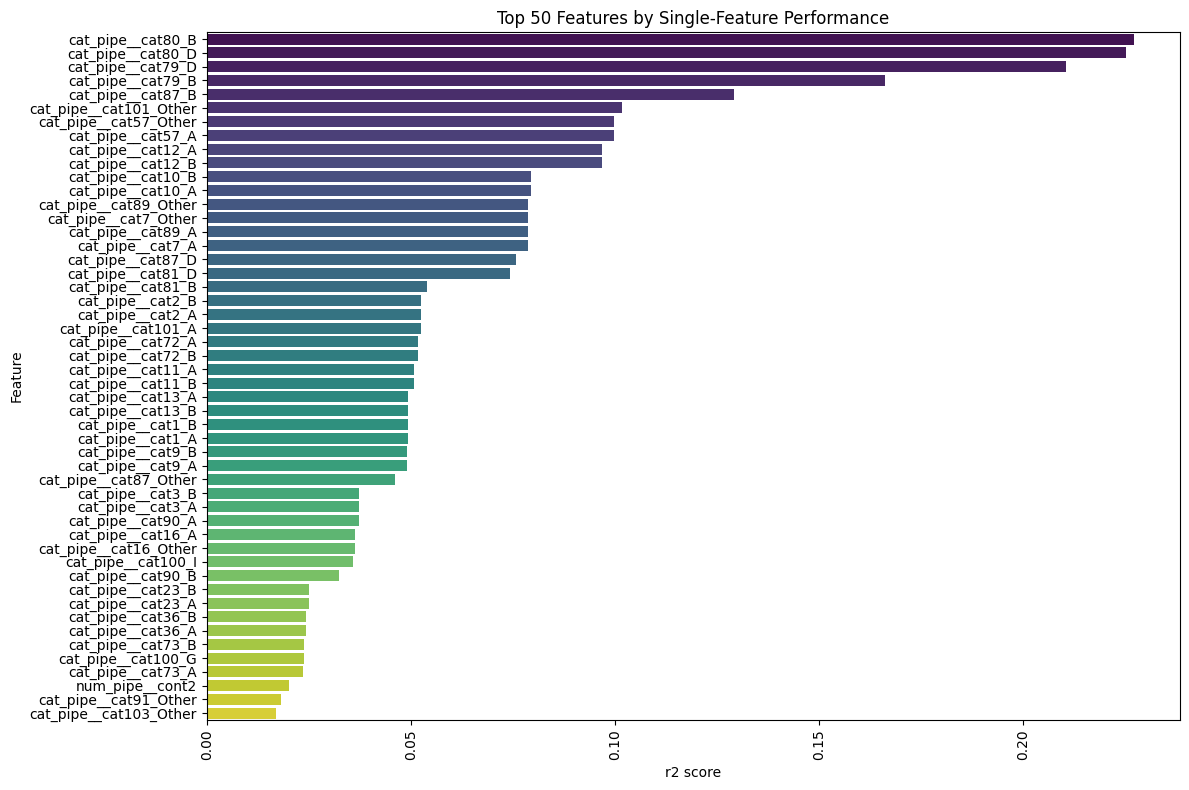

In [145]:
plt.figure(figsize=(12, 8))

sns.barplot(
    data=perf_df.sort_values(by="score", ascending=False).head(50),
    x="score",
    y="feature",
    palette="viridis"
)

plt.xlabel("r2 score")
plt.ylabel("Feature")
plt.title("Top 50 Features by Single-Feature Performance")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()